# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer will likely receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

**Description of the data**
```
/datasets/insurance_us.csv
    Features: insured person's gender, age, salary, and number of family members.
    Target: number of insurance benefits received by an insured person over the last five years.
```

# Data Preprocessing & Exploration

## Initialization

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from collections import Counter
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from IPython.display import display, HTML, display_html

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_colwidth', None) # no wrap
pd.set_option('display.max_columns', 100) # columns number
pd.set_option('display.max_rows', 50) # rows number

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [4]:
try:
    df = pd.read_csv('./datasets/insurance_us.csv')
except:
    df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [5]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', \
                        'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [6]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
1127,1,35.000,30700.000,1,0
4713,0,31.000,33500.000,1,0
573,1,45.000,27200.000,1,1
3747,0,29.000,42900.000,4,0
356,1,30.000,31600.000,3,0
817,0,24.000,30000.000,0,0
1604,0,26.000,43400.000,1,0
3778,1,18.000,22000.000,1,0
1125,0,28.000,29800.000,1,0
4317,1,29.000,29100.000,1,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [8]:
# we may want to fix the age type (from float to int) though this is not critical
df['age'] = df['age'].astype(int)

In [9]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [10]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000,5000.000,5000.000,5000.000,5000.000
mean,0.499,30.953,39916.360,1.194,0.148
std,0.500,8.441,9900.084,1.091,0.463
min,0.000,18.000,5300.000,0.000,0.000
25%,0.000,24.000,33300.000,0.000,0.000
50%,0.000,30.000,40200.000,1.000,0.000
75%,1.000,37.000,46600.000,2.000,0.000
max,1.000,65.000,79000.000,6.000,5.000


In [11]:
print(f'Duplicates in data: {df.duplicated().sum()} ({(df.duplicated().sum() / df.shape[0]):.2%})')

Duplicates in data: 153 (3.06%)


In [12]:
df.drop_duplicates(keep=False, inplace=True, ignore_index=True)

**Conclusion**

There are no missing values in this dataset.

We changed data type of the `age` feature to integer.  

We had 3% of duplicates to drop.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

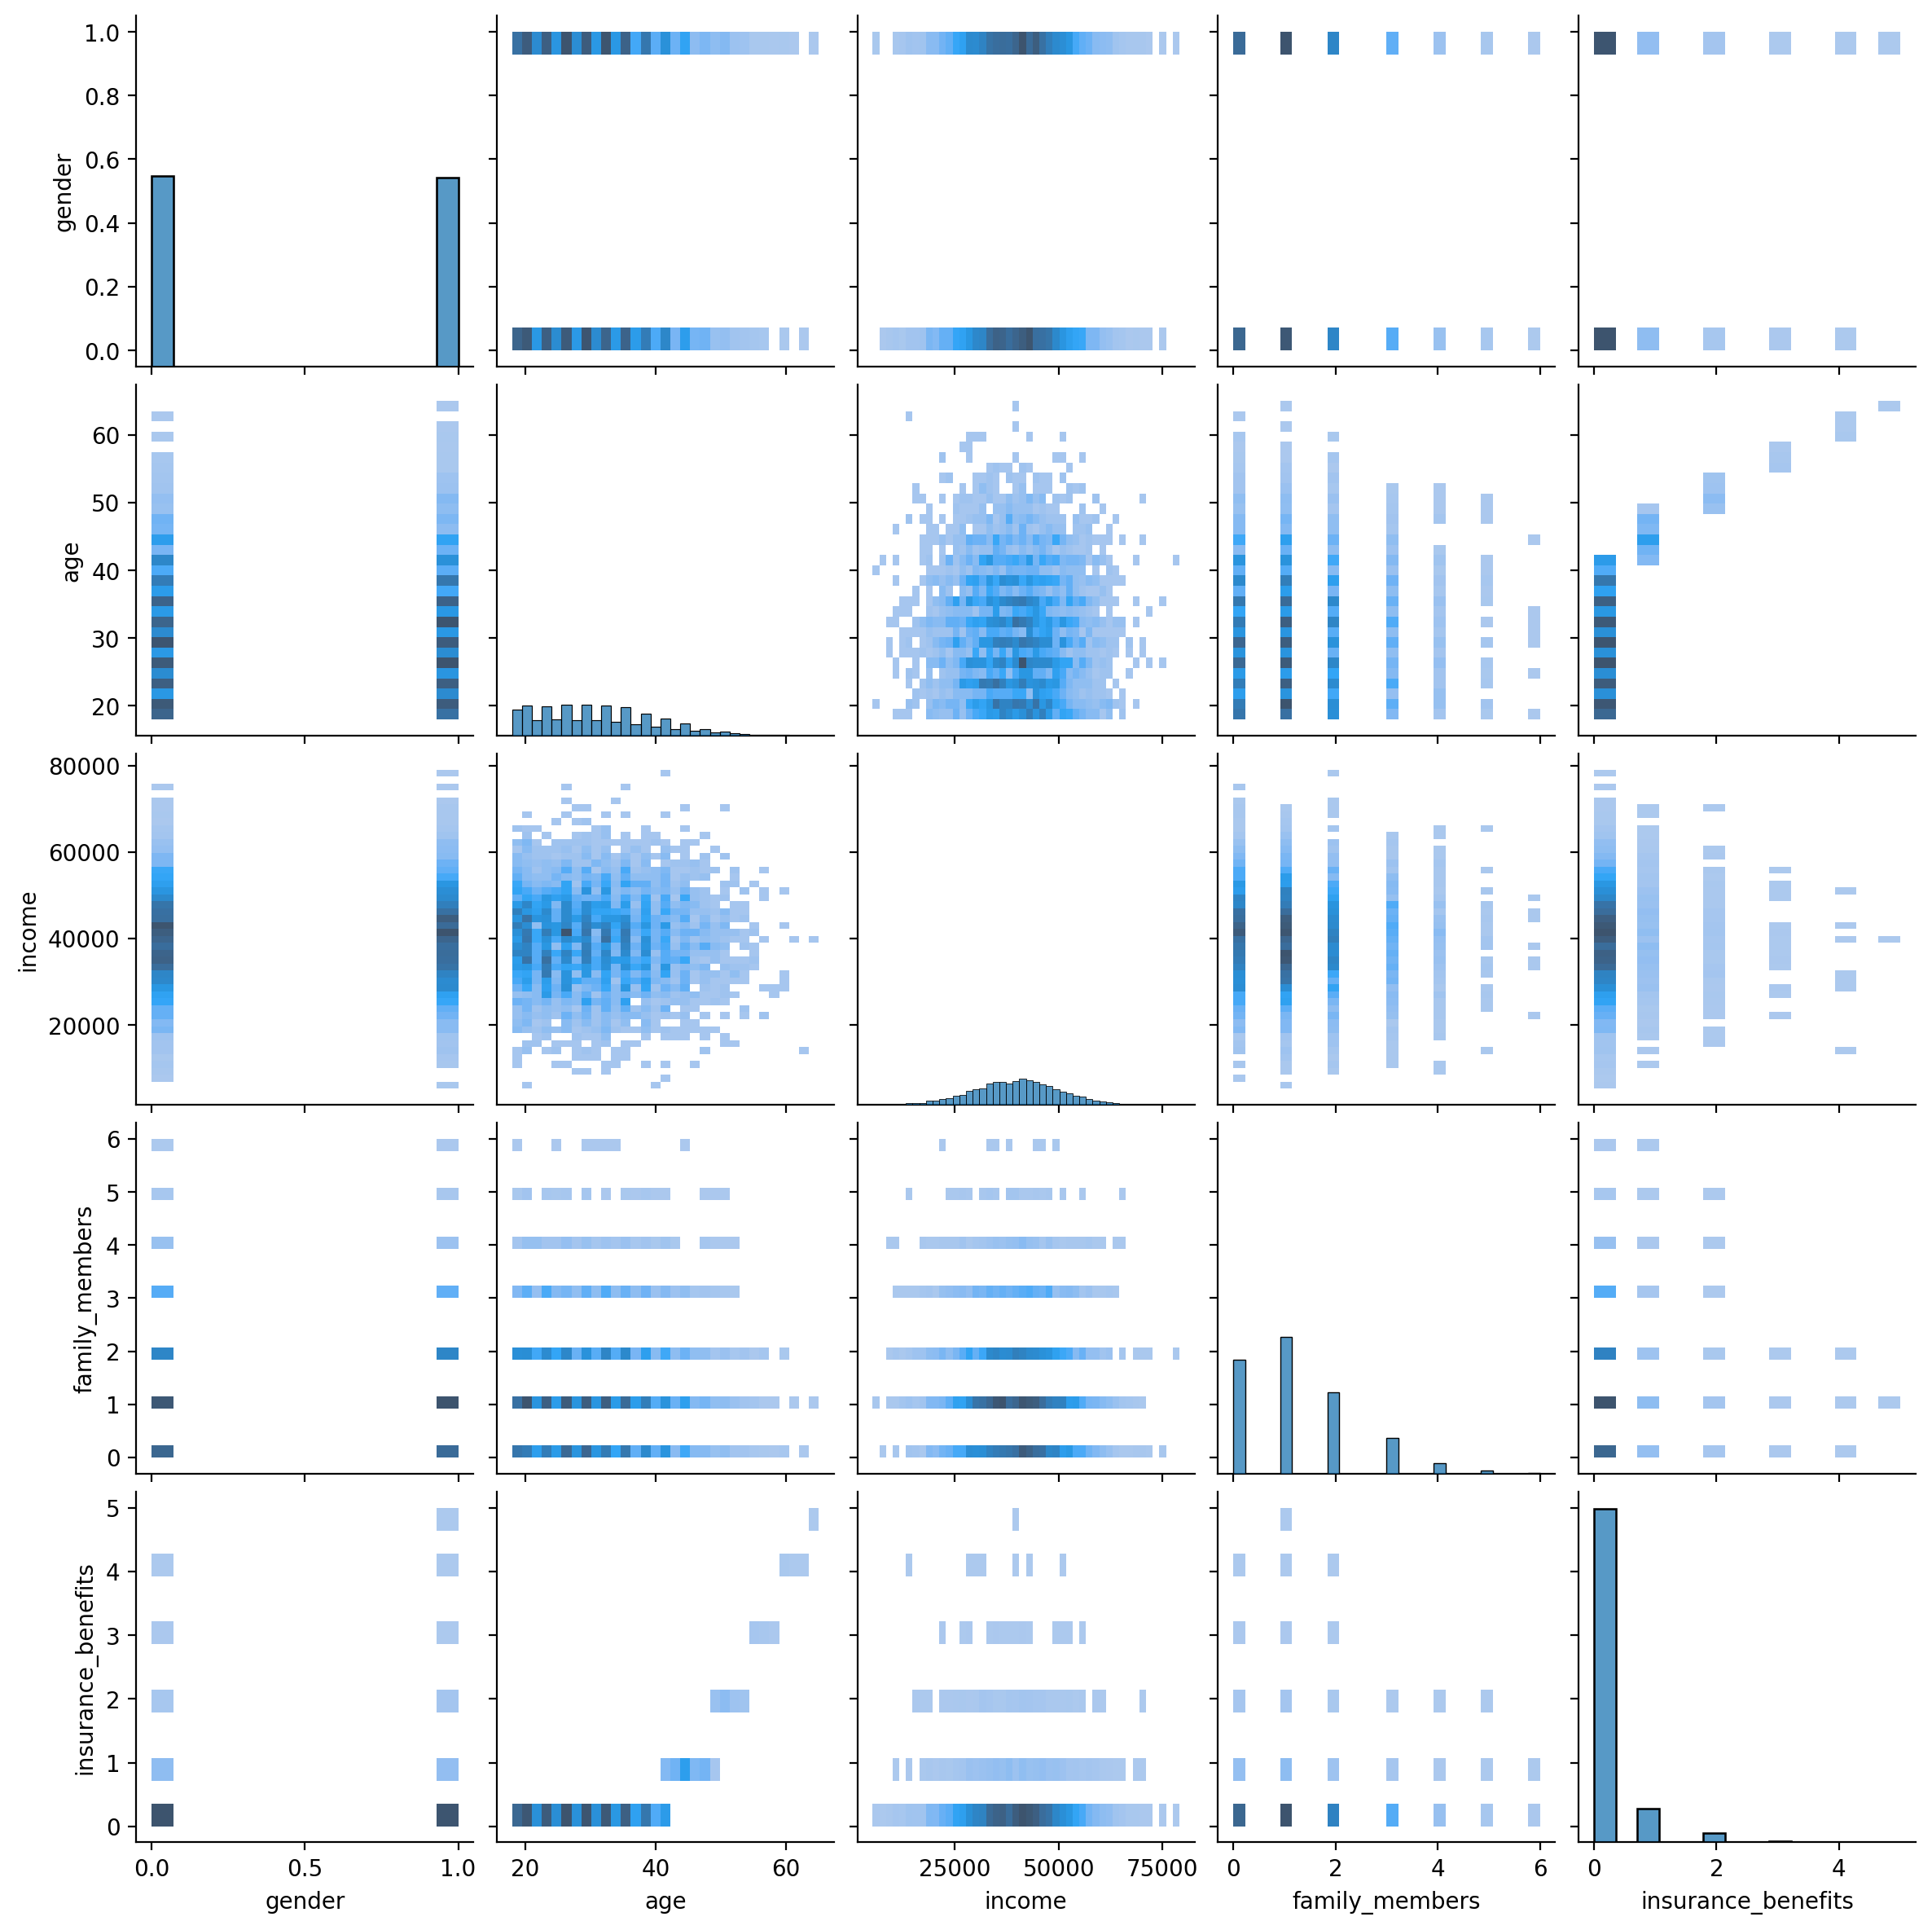

In [13]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

Scaling the data.

In [15]:
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled[feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [16]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1334,1.000,0.446,0.332,0.000,0
1157,1.000,0.338,0.686,0.167,0
2684,0.000,0.538,0.476,0.000,0
286,0.000,0.385,0.414,0.167,0
1408,0.000,0.369,0.557,0.167,0


In [17]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """
    p = 1 if metric == 'manhattan' else 2
    nbrs = sklearn.neighbors.NearestNeighbors(p=p)
    nbrs.fit(df.values)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Now, let's get similar records for a given one for every combination

In [18]:
res_manhattan = get_knn(df[feature_names], 42, 4, 'manhattan')
res_manhattan

,gender,age,income,family_members,distance
42,0,30,31600.000,2,0.000
4075,0,30,31600.000,1,1.000
327,1,30,31600.000,3,2.000
2757,1,30,31600.000,0,3.000


In [19]:
res_euclidean = get_knn(df[feature_names], 42, 4, 'euclidean')
res_euclidean

,gender,age,income,family_members,distance
42,0,30,31600.000,2,0.000
4075,0,30,31600.000,1,1.000
327,1,30,31600.000,3,1.414
2757,1,30,31600.000,0,2.236


In [20]:
res_manhattan_scaled = get_knn(df_scaled[feature_names], 42, 4, 'manhattan')
res_manhattan_scaled

,gender,age,income,family_members,distance
42,0.000,0.462,0.400,0.333,0.000
1526,0.000,0.477,0.395,0.333,0.020
1587,0.000,0.446,0.406,0.333,0.022
761,0.000,0.446,0.408,0.333,0.023


In [21]:
res_euclidean_scaled = get_knn(df_scaled[feature_names], 42, 4, 'euclidean')
res_euclidean_scaled

,gender,age,income,family_members,distance
42,0.000,0.462,0.400,0.333,0.000
1526,0.000,0.477,0.395,0.333,0.016
1587,0.000,0.446,0.406,0.333,0.017
761,0.000,0.446,0.408,0.333,0.017


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Scaled and unscaled data give different results. With raw data, everything except income doesn't affect the vectors a lot.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The results of finding using the Manhattan distance metric are very close. For scaled data, the distance to the top 3 is 0.20-0.23.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [22]:
# calculate the target
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0) * 1
df_scaled['insurance_benefits_received'] = (df_scaled['insurance_benefits'] > 0) * 1

In [23]:
# check for the class imbalance with value_counts()
df['insurance_benefits_received'].value_counts(normalize=True)

0   0.880
1   0.120
Name: insurance_benefits_received, dtype: float64

We have a vast imbalance of classes, so we have to resample the train part after splitting.

In [24]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)

    return features_upsampled, target_upsampled

In [25]:
print('Unscaled')
X_train, X_test, y_train, y_test = train_test_split(df[feature_names], df['insurance_benefits_received'],\
                                                    test_size=0.3, random_state=42)

print('Train set length:', X_train.shape[0])
print('Test set length:', X_test.shape[0])

X_train, y_train = upsample(X_train, y_train, int(y_train.shape[0]/y_train.sum()))

print()
print('After resampling')
print('Train set length:', X_train.shape[0])
print('Test set length:', X_test.shape[0])

Unscaled
Train set length: 3290
Test set length: 1410

After resampling
Train set length: 6048
Test set length: 1410


In [26]:
print('Scaled')
X_scale_train, X_scale_test, y_scale_train, y_scale_test = train_test_split(df_scaled[feature_names],\
                                                            df_scaled['insurance_benefits_received'],\
                                                            test_size=0.3, random_state=42)

print('Train set length:', X_scale_train.shape[0])
print('Test set length:', X_scale_test.shape[0])

rep = int(df['insurance_benefits_received'].shape[0]/df['insurance_benefits_received'].sum())
X_train, y_train = upsample(X_train, y_train, rep)


X_scale_train, y_scale_train = upsample(X_scale_train, y_scale_train, \
                                        int(y_scale_train.shape[0]/y_scale_train.sum()))

print()
print('After resampling')
print('Train set length:', X_scale_train.shape[0])
print('Test set length:', X_scale_test.shape[0])

Scaled
Train set length: 3290
Test set length: 1410

After resampling
Train set length: 6048
Test set length: 1410


Let's train KNeighborsClassifier for k=1..10 on unscaled data and measure its quality with the F1 metric.

In [27]:
k = 1
f1 = 0
for i in range(1, 11):
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, y_train)
    print(f'k={i} F1: {sklearn.metrics.f1_score(y_test, model.predict(X_test)):.3f}') 

k=1 F1: 0.673
k=2 F1: 0.673
k=3 F1: 0.659
k=4 F1: 0.659
k=5 F1: 0.589
k=6 F1: 0.589
k=7 F1: 0.539
k=8 F1: 0.539
k=9 F1: 0.472
k=10 F1: 0.472


Now the same on scaled data.

In [28]:
k = 1
f1 = 0
for i in range(1, 11):
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=i)
    model.fit(X_scale_train, y_scale_train)
    print(f'k={i} F1: {sklearn.metrics.f1_score(y_scale_test, model.predict(X_scale_test)):.3f}') 

k=1 F1: 0.943
k=2 F1: 0.943
k=3 F1: 0.944
k=4 F1: 0.944
k=5 F1: 0.921
k=6 F1: 0.921
k=7 F1: 0.902
k=8 F1: 0.902
k=9 F1: 0.884
k=10 F1: 0.884


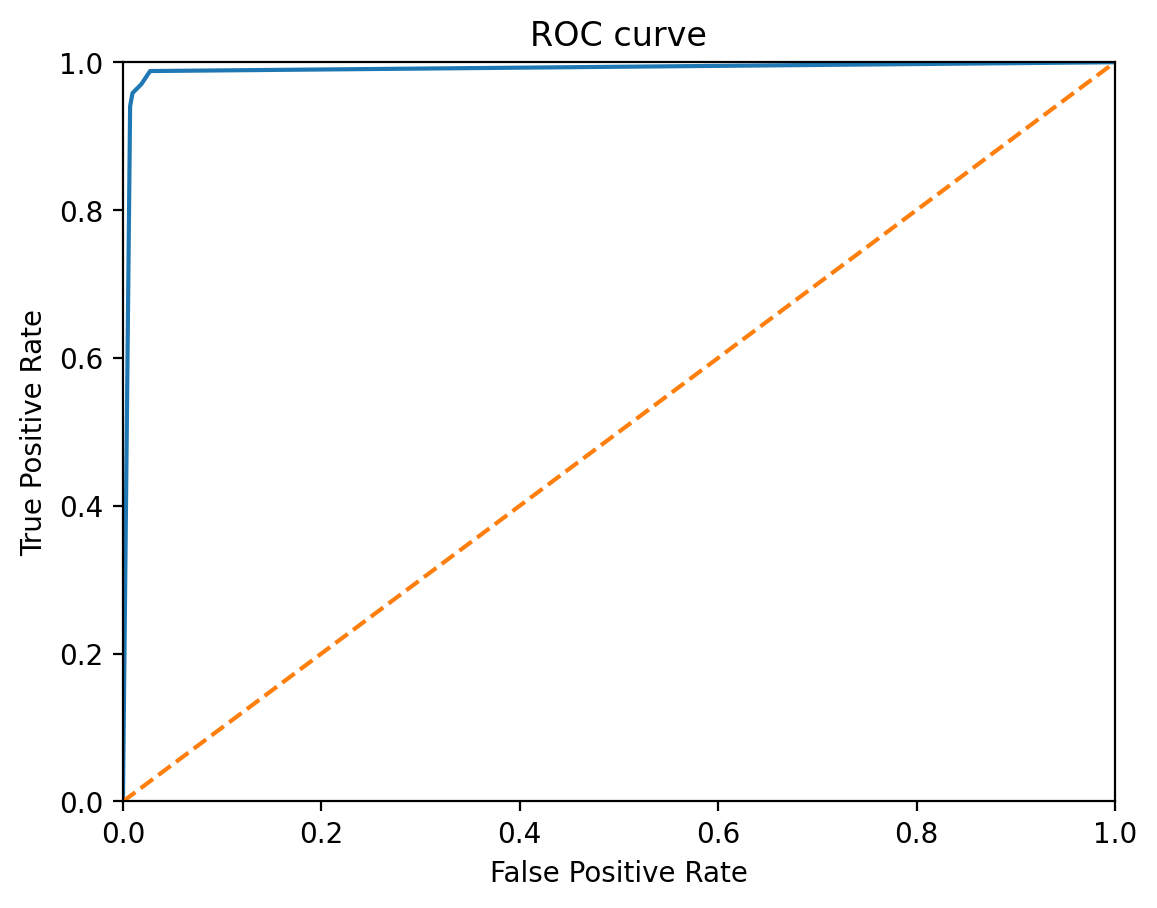

In [29]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=4)
model.fit(X_scale_train, y_scale_train)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_scale_test, model.predict_proba(X_scale_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

Let's build a dummy model and look at its F1 metric and confusion matrix.

In [30]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [31]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [32]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, df.shape[0])
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.88042553 0.        ]
 [0.11957447 0.        ]]

The probability: 0.12
F1: 0.14
Confusion Matrix
[[0.77957447 0.10085106]
 [0.10319149 0.01638298]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.44787234 0.43255319]
 [0.05829787 0.0612766 ]]

The probability: 1.00
F1: 0.21
Confusion Matrix
[[0.         0.88042553]
 [0.         0.11957447]]



**Conclusion**  
The KNeighborsClassifier performs better on scaled data. The best results are with 3 or 4 neighbors.  
The dummy model based on random choice with different probabilities gives a very low F1 metric.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [33]:
class MyLinearRegression:
    def __init__(self):        
        self.weights = None
    
    def fit(self, X, y):
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [34]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

Predicting insurance_benefits on unscaled data.

In [35]:
X = df[feature_names].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.55531621e-01  1.36770247e-02  3.62700655e-02 -1.35591572e-07
 -1.55692557e-02]
RMSE: 0.37
R2: 0.66


Predicting insurance_benefits on scaled data.

In [36]:
X = df_scaled[feature_names].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_scale_train, X_scale_test, y_scale_train, y_scale_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr_scale = MyLinearRegression()

lr_scale.fit(X_scale_train, y_scale_train)
print(lr_scale.weights)

y_test_scale_pred = lr_scale.predict(X_scale_test)
eval_regressor(y_scale_test, y_test_scale_pred)

[-0.95553162  0.01367702  2.35755426 -0.01071173 -0.09341553]
RMSE: 0.37
R2: 0.66


**Conclusion**  
Training the Linear Regression model on both scaled and unscaled data gives us a 0.37 RMSE metric.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [37]:
df_pn = df[feature_names]
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [38]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [39]:
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

Can you guess the customers' ages or income after the transformation?

In [40]:
df_obfuscate = df_pn.dot(P)
df_obfuscate.columns = feature_names

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [41]:
df_restored = df_obfuscate.dot(np.linalg.inv(P))
df_restored.columns = feature_names

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [42]:
display(df_pn.head(3))
display(df_obfuscate.head(3))
display(df_restored.head(3))

,gender,age,income,family_members
0,1,41,49600.000,1
1,0,46,38000.000,1
2,0,29,21000.000,0


,gender,age,income,family_members
0,6359.715,22380.405,18424.091,46000.697
1,4873.294,17160.367,14125.781,35253.456
2,2693.117,9486.398,7808.832,19484.861


,gender,age,income,family_members
0,1.000,41.000,49600.000,1.000
1,-0.000,46.000,38000.000,1.000
2,-0.000,29.000,21000.000,0.000


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

**Conclusion**  
Obfuscating and restoring sensitive data gives us the same values, but they all are of float data type. So instead of 0 in `gender,` we see -0.000.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

$w = (X^T X)^{-1} X^T y $

$w_P = [(XP)^T XP]^{-1} (XP)^T y = P^{-1}[P^T X^T X]^{-1} P^T X^T y  = P^{-1} (X^T X)^{-1} P^{-T} P^T X^T y = P^{-1} (X^T X)^{-1} (P^{-1} P)^T X^T y = P^{-1} (X^T X)^{-1} X^T y $


**Analytical proof**

$y = X w$  
$y = X P w_P $  

$X (X^T X)^{-1} X^T y = X P P^{-1} (X^T X)^{-1} X^T y$  
$X (X^T X)^{-1} X^T y = X (X^T X)^{-1} X^T y$

**Conclusion**  
Obfuscating the features doesn't affect the target, and the quality of the regression model will be the same.

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [43]:
def get_regression(X, y, obfuscate = False):
    
    """
    Run linear regression with or without obfuscation 

    :param df: pandas DataFrame 
    :param obfuscate: flag for obfuscation
    """
    if obfuscate:
        print('Obfuscated data')
        while(True):
            try:
                P = rng.random(size=(X.shape[1], X.shape[1]))
                np.linalg.inv(P)
                break
            except:
                continue        
        X = X.dot(P)
    else:
        print('Raw data')
    X_scale_train, X_scale_test, y_scale_train, y_scale_test = train_test_split(X, y,\
                                                            test_size=0.3, random_state=42)

    lr = sklearn.linear_model.LinearRegression()
    lr.fit(X_scale_train, y_scale_train)

    y_test_scale_pred = lr.predict(X_scale_test)
    print (y_test_scale_pred[:5])    

    eval_regressor(y_scale_test, y_test_scale_pred)

In [44]:
X = df_scaled[feature_names].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

get_regression(X, y, )
print()
get_regression(X, y, True)

Raw data
[ 0.66879019 -0.01916141 -0.15066561  0.18575822  0.19835051]
RMSE: 0.37
R2: 0.66

Obfuscated data
[ 0.66879019 -0.01916141 -0.15066561  0.18575822  0.19835051]
RMSE: 0.37
R2: 0.66


**Conclusion**  
We got the same target with the given features and obfuscated ones.

# Conclusions

Using some data on the insurance customers, we explored several tasks: 
1. Classification of customers using the KNN method with different distance metrics. We saw that scaling is necessary for this algorithm.
2. Predicting if `insurance_benefits` is more than zero like a binary classification task; KNN gives much better results than a dummy model.
3. Prediction of insurance benefits number with a linear regression model.
4. Exploring the possibilities of data obfuscation for the regression model. We ensured that the masked data gave the same result as the raw.